### Libraries

In [22]:
# install.packages(c("mclust", "stats", "graphics", "wrassp"))
library(wrassp)
library(mclust)

Loading required package: tibble

Package 'mclust' version 6.1.2
Type 'citation("mclust")' for citing this R package in publications.



## Data

In [23]:
set.seed(207) 
system("git clone https://github.com/danpinocontrollino/Roberto-Brambini.git")
setwd("/content/Roberto-Brambini")


# --- USER PATHS ---
path_train    <- "Aloha/Pollly"
path_outliers <- "Aloha/Outliers"
path_test     <- "Aloha/Polly Verdi"

# Data collection Notes

## **"ALOHA"**



Why this word?

**Vowel Dominance**: "Aloha" is composed almost entirely of voiced sounds. Unlike
words with "hidden" silence (like the "t" in "Cat" or the "p" in "Apple"), the vocal folds vibrate throughout almost the entire duration of "Aloha." This gives you a continuous, beautiful pitch curve with very few gaps ($NAs$).

**"Hump" Geometry**: The "o" sound naturally creates a peak in pitch for most speakers, while the "a" sounds at the beginning and end provide stable baselines. This mimics the synthetic "sine wave hump" data you've already been practicing with.

 **Duration**: It is long enough to have distinct phases (start, middle, end) but short enough that you won't get exhausted recording it 100 times.

## collecting Tips

To get valid conformal bands, your recordings must be **exchangeable** (collected under the same conditions). SAY THIS IN THE REPORT, VERY IMPORTANT, THE PROFESSOR TALK ABOUT THIS PROPERTY IN THE MEETING

The Microphone: Use the same microphone for every recording. Keep it at a fixed distance (about 10–15cm) from your mouth.

The "Anti-Robot" Rule: Do not try to speak perfectly. Conformal bands measure uncertainty; if you act like a robot, your bands will be artificially narrow and won't represent your actual voice. Speak at a natural, consistent volume.

Environment: Record in a quiet room with minimal echo (closets with clothes are great "poor man's" recording studios).

You need to turn one long recording of 100 words into 100 individual files.

Software: Use Audacity (Free), FL Studio...

The Process: * Do NOT "Time-Stretch" or "Warp": Never use music software to make the clips the same length. This destroys the raw data.

Padding: Leave a tiny bit of silence (e.g., 50ms) before and after the word.

Export: Name them sequentially (word_01.wav, word_02.wav, etc.).

## Pitch Extraction

In speech science, "pitch" is $F_0$ (the fundamental frequency). You need a specialized algorithm to extract this from the raw waveform.

In [24]:
# #library(wrassp)
# #library(mclust)

# # Get a list of all your wav files
# #files <- list.files(pattern = "\\.wav$")

# # Extract pitch using the KSV algorithm
# pitch_list <- lapply(files, function(f) {
#   res <- ksvF0(f, toFile = FALSE)
#   # F0 track is a matrix, convert to vector
#   f0_data <- res$F0
#   if(is.matrix(f0_data)) as.vector(f0_data) else f0_data
# })

Because you didn't use music software to stretch the audio (good job!), your pitch vectors will all have different lengths. You must standardize them to a common grid (e.g., 100 points) so you can put them in a matrix.

## Preprocessing

When you extract the pitch, the algorithm will return 0 or NA for the silence. You should write a script that finds the first and last "voiced" point and throws everything else away.

The Logic:

Extract: Get the pitch for the whole clip (including silence).

Threshold: Identify all points where Pitch > 50 Hz (human pitch rarely goes lower).

Crop: Keep only the segment from the first voiced point to the last voiced point.

Normalize: Stretch that segment to 100%.

In [ ]:
# Normalization: Maps variable-length recordings to a fixed domain t in [0,1]
normalize_pitch <- function(raw_pitch) {
  # Filter silence/noise (assume > 0 Hz is voiced)
  voiced_part <- raw_pitch[raw_pitch > 0]
  if (length(voiced_part) < 5) return(rep(NA, 100)) 
  
  # Linear Interpolation to 100 points
  approx(x = seq(0, 1, length.out = length(voiced_part)), 
         y = voiced_part, 
         xout = seq(0, 1, length.out = 100))$y
}

# Loader Helper
load_and_align <- function(path) {
  if(!dir.exists(path)) return(NULL)
  files <- list.files(path = path, pattern = "\\.wav$", full.names = TRUE)
  if(length(files) == 0) return(NULL)
  
  raw <- lapply(files, function(f) {
    res <- ksvF0(f, toFile = FALSE)
    # ksvF0 returns F0 as a matrix, convert to vector
    f0 <- res$F0
    if(is.matrix(f0)) as.vector(f0) else f0
  })
  
  aligned <- lapply(raw, normalize_pitch)
  mat <- do.call(rbind, aligned)
  return(na.omit(mat))
}

# Load Data
X_matrix   <- load_and_align(path_train)
X_outliers <- load_and_align(path_outliers)
X_test     <- load_and_align(path_test)

data_matrix <- X_matrix # Rename to match notebook pattern

# Data Splitting Notes

PA = person A

*   Training: PA, same word (100 rec)
*   Test1: PA, same word (20 rec)-> check if the bands contains them
* Test2: other person, same word (10 rec tot.) -> check if they are outside the bands ( OPTIONAL )




# Describe your data


### Functional means and variances

In [26]:
dim(data_matrix) # Check dimensions


[1] 120 100

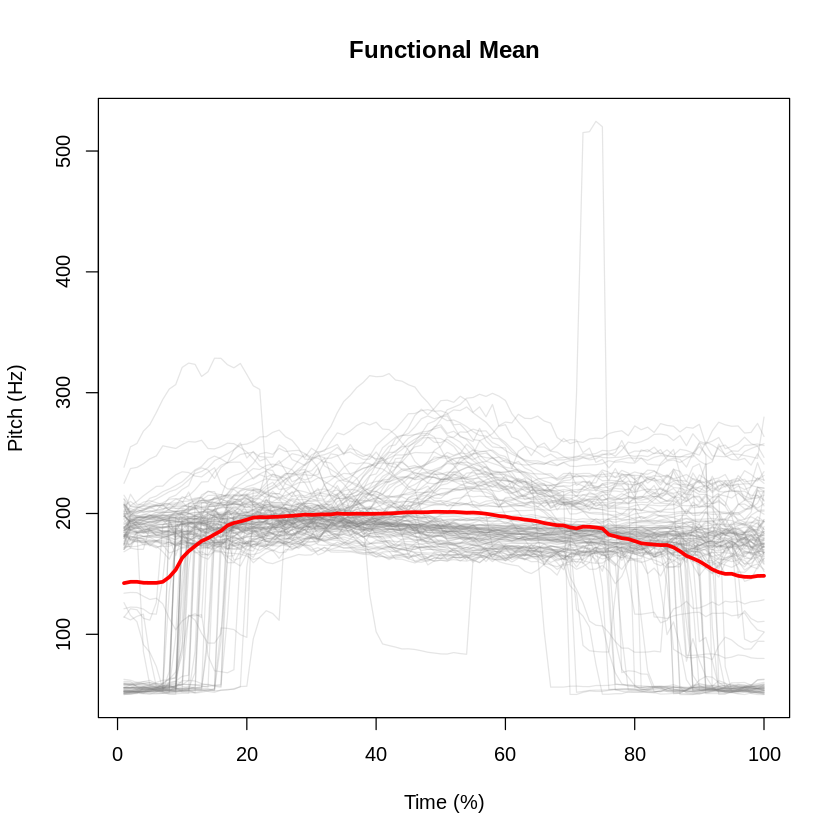

In [ ]:
sddfata# A. Functional Mean
# Theory: Represents the "prototypical" shape of the word Aloha.
functional_mean <- colMeans(data_matrix)
matplot(t(data_matrix), type = "l", lty = 1, col = rgb(0.5, 0.5, 0.5, 0.2),
        main = "Functional Mean", ylab = "Pitch (Hz)", xlab = "Time (%)")
lines(functional_mean, col = "red", lwd = 3)

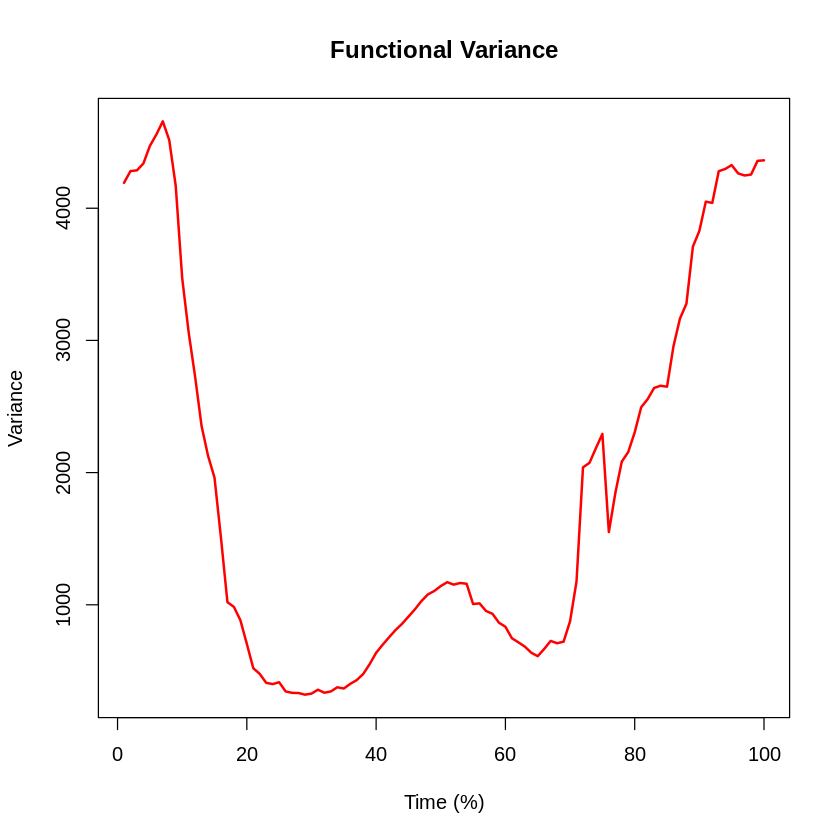

In [28]:
# B. Functional Variance
# Theory: Shows where the speakers differ the most (usually at the start/end or during the 'h').
functional_var <- apply(data_matrix, 2, var)
plot(functional_var, type = "l", col = "red", lwd = 2,
     main = "Functional Variance", xlab = "Time (%)", ylab = "Variance")


 ### Covariance and correlation functions

In [29]:
cor_matrix <- cor(data_matrix)

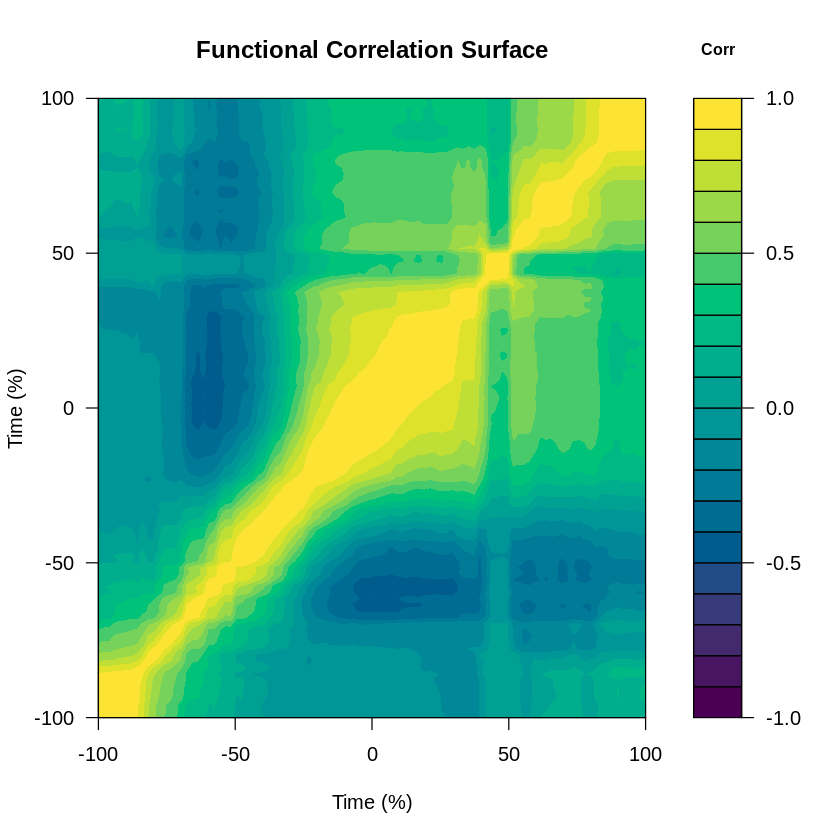

In [ ]:
time_grid <- seq(-1, 1, length.out = 100)

t_points <- time_grid * 100


my_colors <- hcl.colors(20, "Viridis")

filled.contour(x = t_points,
               y = t_points,
               z = cor_matrix,
               # Use 'levels' to force the scale from 0 to 1
               levels = seq(-1, 1, length.out = 21),
               color.palette = function(n) my_colors,
               xlab = "Time (%)",
               ylab = "Time (%)",
               main = "Functional Correlation Surface",
               key.title = title(main = "Corr", cex.main = 0.8))

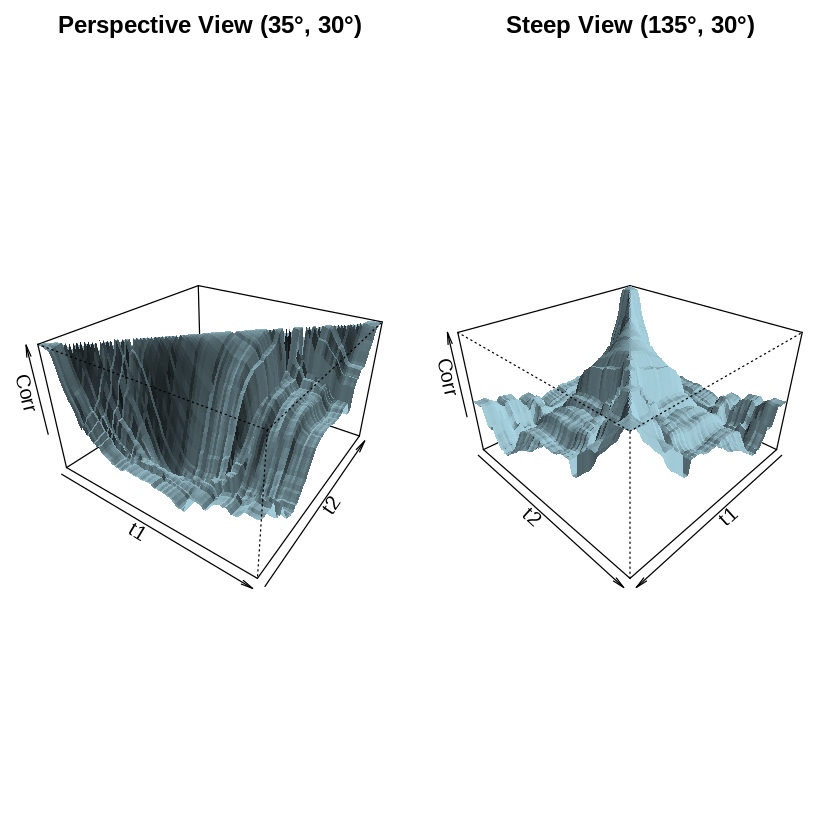

In [31]:
t_points <- time_grid * 100

# 2. Setup a 1x2 plotting area
layout(matrix(c(1, 2), nrow = 1))
par(mar = c(1, 1, 2, 1)) # Tight margins

# --- VIEW 1: Perspective View (Classic) ---
# theta = 35 (side rotation), phi = 30 (elevation)
persp(x = t_points, y = t_points, z = cor_matrix,
      theta = 35, phi = 30,
      expand = 0.6, col = "lightblue", shade = 0.4, border = NA,
      main = "Perspective View (35°, 30°)",
      xlab = "t1", ylab = "t2", zlab = "Corr")

# --- VIEW 2: High-Angle View (To see the 'Ridge' width) ---
# theta = 135 (rotated to other side), phi = 50 (looking more downward)
persp(x = t_points, y = t_points, z = cor_matrix,
      theta = 135, phi = 30,
      expand = 0.6, col = "lightblue", shade = 0.4, border = NA,
      main = "Steep View (135°, 30°)",
      xlab = "t1", ylab = "t2", zlab = "Corr")

# Reset layout
layout(1)

#### Possible comments

1. The Width of the "Diagonal Ridge" (Local Dependency)Look at the thick band of high correlation (the "warm" colors) running from $(0,0)$ to $(100,100)$.A Wide Ridge: Suggests high persistence. If the ridge is wide, the pitch at $t=20$ is almost the same as $t=30$. The process is smooth and changes slowly.A Narrow Ridge: Suggests the signal is "noisy" or highly volatile. The pitch at $t=20$ tells you very little about $t=25$.


2. The "Shoulder" Decay (Phase Stability)Notice how the color fades as you move perpendicularly away from the diagonal.In your pitch data, the ridge likely stays fairly consistent in the middle but might narrow or "blur" toward the end.This confirms your observation about the increasing variance: because the shift parameter pushes some curves forward and others back, the "synchronization" between curves breaks down. Points far apart in time lose their linear relationship faster at the end of the recording than at the beginning.

3. Off-Diagonal Blocks (Global Structure)Check the "empty" corners (e.g., the correlation between $t=10$ and $t=90$).Low Correlation (Deep Purple/Blue): This is normal for a single "hump." The start of the pitch rise has nothing to do with the end of the pitch fall.Secondary Peaks: If you saw a bright spot at $(20, 80)$, it would imply a cyclical relationship—meaning when the pitch is high at the start, it is predictably high (or low) at the end. In your current sine-wave data, you likely won't see this unless you generate two humps.

4. Symmetry and CurvatureThe plot is perfectly symmetrical across the diagonal ($Cor(t_1, t_2) = Cor(t_2, t_1)$). However, look for non-parallel contours:If the contours are parallel to the diagonal, the process is Stationary (the relationship between two points only depends on the distance between them).In your data, the contours will likely curve. This is a sign of Non-stationarity. The "rules" of the pitch change depending on whether you are at the start, the peak, or the end of the sound.

# Functional conformal prediction Bands
we chose the algorithm in the section 3

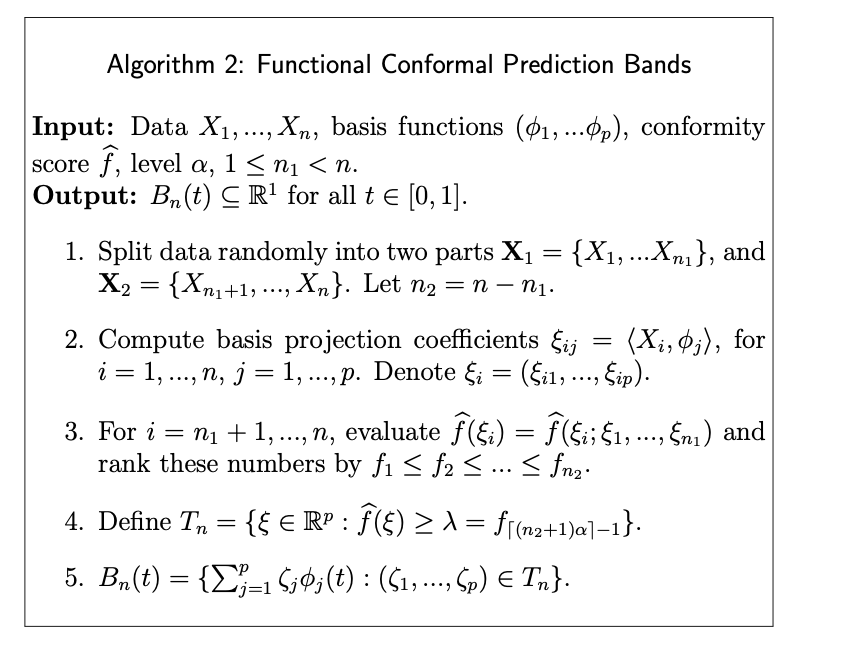

## Setup and FPCA (The Projection)

In [32]:
# Split Data (Inductive Conformal Prediction)
n <- nrow(data_matrix)
n1 <- floor(n * 0.6)
idx_train <- sample(1:n, n1)

data_train <- data_matrix[idx_train, ] 
data_calib <- data_matrix[-idx_train, ] 

# Functional PCA
# Theory: Projects infinite-dim functions to low-dim coefficients (scores).
pca_model <- prcomp(data_train, center = TRUE, scale. = FALSE)
K_components <- 2 
coeff_train <- pca_model$x[, 1:K_components]
coeff_calib <- predict(pca_model, newdata = data_calib)[, 1:K_components]

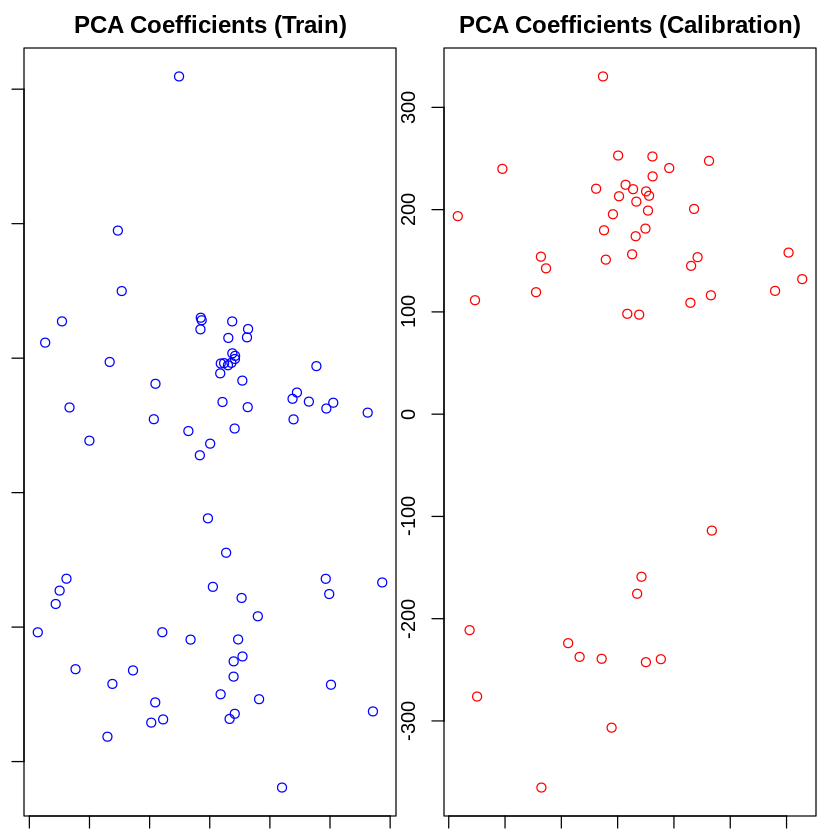

In [33]:
# Plot coefficient
layout(matrix(c(1, 2), nrow = 1))
par(mar = c(1, 1, 2, 1)) # Tight margins

plot(coeff_train, main = "PCA Coefficients (Train)", xlab = "PC1", ylab = "PC2", col = "blue")
plot(coeff_calib, main = "PCA Coefficients (Calibration)", xlab = "PC1", ylab = "PC2", col = "red")

## Conformity measure: Gaussian Mixture Modeling

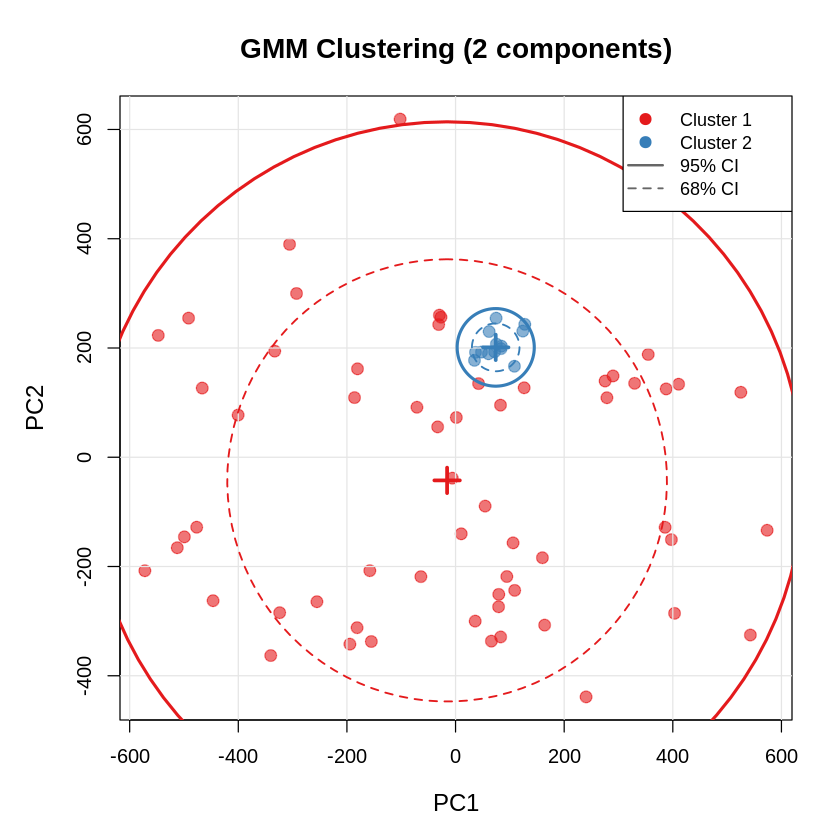

In [34]:
library(mclust)

gmm_model <- densityMclust(coeff_train, G = 1:4, plot = FALSE)

# Get parameters
means <- gmm_model$parameters$mean
sigmas <- gmm_model$parameters$variance$sigma
props <- gmm_model$parameters$pro
num_clusters <- gmm_model$G

# --- GMM Visualization with Ellipsoids ---
# Get cluster assignments
z_probs <- predict(gmm_model, newdata = coeff_train, what = "z")
clusters <- apply(z_probs, 1, which.max)

# Nice color palette
pal <- c("#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00")
cluster_colors <- pal[1:max(num_clusters, 1)]

# Helper function to draw covariance ellipse
draw_ellipse <- function(mu, sigma, level = 0.95, col, lwd = 2, lty = 1) {
  # Chi-squared quantile for confidence level
  chi_val <- qchisq(level, df = 2)
  
  # Eigendecomposition
  eig <- eigen(sigma)
  angles <- seq(0, 2 * pi, length.out = 100)
  
  # Scale by eigenvalues and chi-squared
  ellipse <- cbind(cos(angles), sin(angles)) %*% 
             diag(sqrt(chi_val * eig$values)) %*% t(eig$vectors)
  ellipse <- sweep(ellipse, 2, mu, "+")
  
  lines(ellipse, col = col, lwd = lwd, lty = lty)
}

# Plot
par(mar = c(5, 5, 4, 2), bg = "white")
plot(coeff_train[,1], coeff_train[,2],
     pch = 19, cex = 1.3,
     col = scales::alpha(cluster_colors[clusters], 0.6),
     xlab = "PC1", ylab = "PC2",
     main = paste0("GMM Clustering (", num_clusters, " component", 
                   ifelse(num_clusters > 1, "s", ""), ")"),
     cex.lab = 1.2, cex.main = 1.4)
grid(col = "gray90", lty = 1)

# Add ellipses for each cluster (95% and 68% confidence)
for(k in 1:num_clusters) {
  mu_k <- means[, k]
  sigma_k <- if(length(dim(sigmas)) == 3) sigmas[,,k] else sigmas
  
  # 95% ellipse (solid)
  draw_ellipse(mu_k, sigma_k, level = 0.95, col = cluster_colors[k], lwd = 2.5)
  # 68% ellipse (dashed)
  draw_ellipse(mu_k, sigma_k, level = 0.68, col = cluster_colors[k], lwd = 1.5, lty = 2)
  
  # Cluster center
  points(mu_k[1], mu_k[2], pch = 3, cex = 2, lwd = 3, col = cluster_colors[k])
}

# Legend
legend("topright", 
       legend = c(paste0("Cluster ", 1:num_clusters), "95% CI", "68% CI"),
       col = c(cluster_colors[1:num_clusters], "gray40", "gray40"),
       pch = c(rep(19, num_clusters), NA, NA),
       lty = c(rep(NA, num_clusters), 1, 2),
       lwd = c(rep(NA, num_clusters), 2, 1.5),
       pt.cex = 1.2, cex = 0.9, bg = "white")

## Conformal Calibration (Finding Lambda)

In [35]:
calib_densities <- predict(gmm_model, coeff_calib, what = "dens")

# 2. Find the Threshold (Lambda)
alpha <- 0.05
lambda <- quantile(calib_densities, probs = alpha, type = 1, na.rm = TRUE)

print(paste("Threshold Lambda:", lambda))

[1] "Threshold Lambda: 1.48875152382212e-07"


## Building Bands

Before drawing any bands, the method establishes a guarantee in the low-dimensional PCA space.

Let $\xi \in \mathbb{R}^p$ be the vector of PCA scores (coefficients) for a new curve.

We calculated a density threshold $\lambda$ using conformal calibration. This defines a "High Density Region", denoted as $\widehat{C}_{1-\alpha}$:$$\widehat{C}_{1-\alpha} = \left\{ \xi \in \mathbb{R}^p : \widehat{f}(\xi) \ge \lambda \right\}$$

Due to the conformal calibration property, we are guaranteed that for a new observation $\xi_{n+1}$:$$P\left( \xi_{n+1} \in \widehat{C}_{1-\alpha} \right) \ge 1 - \alpha$$(i.e., There is a 95% probability that the coefficients of the new curve fall inside this Blob).

We need to translate this "Blob" of coefficients into a "Tube" of function values.

The relationship between the projected curve $X(t)$ and its coefficients $\xi$ is Linear:$$X(t) = \mu(t) + \phi(t)^T \xi$$

Where:


*   $\mu(t)$ is the mean curve (a scalar at time $t$).
*   $\phi(t) \in \mathbb{R}^p$ is the vector of basis functions (eigenvectors) evaluated at time $t$.
* $\xi \in \mathbb{R}^p$ is the coefficient vector (the variable).

If we know that $\xi$ is somewhere inside the set $\widehat{C}_{1-\alpha}$, then the value of the curve $X(t)$ must be within the range of values generated by all possible $\xi$ in that set.

In [36]:
# --- Setup ---

# 1. Define Time Axis
time_points <- 1:ncol(data_train)

# 2. Extract PCA Basis (The "Skeleton")
phi <- pca_model$rotation[, 1:K_components, drop = FALSE]
mean_curve <- pca_model$center

# 3. Setup Storage for the Bands
# Since we have a Union of Bands, we cannot store just one "upper" and "lower".
# We will store the bounds for EVERY valid cluster in a list.
cluster_bands <- list()
valid_clusters <- integer()


print("Parameters extracted.")

[1] "Parameters extracted."


Constraint Inversion (Defining the Ellipsoids)Theory: The Prediction Set $\widehat{C}_{1-\alpha}$

Since $\hat{f}$ is a Gaussian Mixture Model (GMM), the set of valid coefficients $\widehat{C}_{1-\alpha}$ is a Union of Ellipsoids.

Find this set directly is difficult, so we find a 'slightly' bigger set that contains $\widehat{C}_{1-\alpha}$


We can easly found this superset of $\widehat{C}_{1-\alpha}$ considering separately each cluster ( ellipsoid ) and adjusting the trashold λ into $\frac{\lambda}{K}$
At the end the superset it's just given by the union of ellipsoids.

For every single cluster $k$, the condition $\pi_k f_k(\xi) \ge \frac{\lambda}{K}$

Then:
$$\pi_k \frac{1}{\sqrt{|2\pi \Sigma_k|}} \exp\left(-\frac{1}{2} (\xi - \mu_k)^T \Sigma_k^{-1} (\xi - \mu_k)\right) \ge \frac{\lambda}{K}$$Taking the log and rearranging terms gives us the radius squared ($r^2$):$$(\xi - \mu_k)^T \Sigma_k^{-1} (\xi - \mu_k) \le -2 \ln\left( \frac{\lambda}{\pi_k \cdot C_{k} \cdot K } \right)$$

where $r^2 =  -2 \ln\left( \frac{\lambda}{\pi_k \cdot C_{k} \cdot K } \right)$

the prediction set $\widehat{C}_{1-\alpha}$ for the coefficients is approximated by the union of simpler sets $T_{n,k}$.$$\widehat{C}_{1-\alpha} \subseteq \bigcup_{k=1}^K T_{n,k}$$

Each individual set $T_{n,k}$ is an Ellipsoid defined by the Gaussian inequality:$$T_{n,k} = \left\{ \xi \in \mathbb{R}^J : (\xi - \hat{\mu}_k)^T \hat{\Sigma}_k^{-1} (\xi - \hat{\mu}_k) \le r_k^2 \right\}$$

In [37]:
# --- D2: Calculate Radius (Corrected with Relaxation Factor) ---

cluster_radii  <- numeric(num_clusters)

for (k in 1:num_clusters) {

  # A. Retrieve Parameters
  Sigma_k <- sigmas[, , k]
  pi_k    <- props[k]

  # B. Calculate Gaussian Constant C_k
  if (K_components == 1) {
    det_Sigma <- Sigma_k[1]
    C_k <- (2 * pi)^(-0.5) * det_Sigma^(-0.5)
  } else {
    det_Sigma <- det(Sigma_k)
    C_k <- (2 * pi)^(-K_components/2) * det_Sigma^(-0.5)
  }

  # We divide lambda by the number of clusters (num_clusters)
  # Formula: phi(xi) >= lambda / (K * pi_k)

  relaxed_threshold <- lambda / num_clusters

  term_inside_log <- relaxed_threshold / (pi_k * C_k)

  if (term_inside_log < 1) {
    valid_clusters <- c(valid_clusters, k)
    r_squared <- -2 * log(term_inside_log)
    cluster_radii[k] <- sqrt(r_squared)
  } else {
    cluster_radii[k] <- 0
    # If the term inside the log is greater than one, it means the subset is empty.
  }
}

We have a closed form solution for linear optimization problem constrained with ellipsoid

**The Upper Bound** $U_k(t)$:

$$U_k(t) = \hat{\mu}(t) + \sup_{\xi \in T_{n,k}} (\phi(t)^T \xi)$$

$$U_k(t) = \hat{\mu}(t) + \phi(t)^T \hat{\mu}_k + r_k \sqrt{\phi(t)^T \hat{\Sigma}_k \phi(t)}$$

**The Lower Bound** $L_k(t)$:

$$L_k(t) = \hat{\mu}(t) + \inf_{\xi \in T_{n,k}} (\phi(t)^T \xi)$$

$$L_k(t) = \hat{\mu}(t) + \phi(t)^T \hat{\mu}_k - r_k \sqrt{\phi(t)^T \hat{\Sigma}_k \phi(t)}$$

In [38]:
# --- Project Bands over Time ---

for (k in valid_clusters) {

  # 1. Setup temporary vectors for this specific cluster band
  k_upper <- numeric(length(time_points))
  k_lower <- numeric(length(time_points))

  # 2. Loop through Time
  for (t in 1:length(time_points)) {

    if (K_components == 1) phi_t <- phi[t] else phi_t <- phi[t, ]

    # A. Center Position at time t
    # (Global Mean + Cluster Mean projected)
    center_val <- mean_curve[t] + sum(means[, k] * phi_t)

    # B. Spread (Width) at time t
    # Formula: Radius * sqrt( phi^T * Sigma * phi )
    Sigma_k <- sigmas[, , k]

    if (K_components == 1) {
       var_proj <- phi_t^2 * Sigma_k[1]
    } else {
       var_proj <- t(phi_t) %*% Sigma_k %*% phi_t
    }

    spread <- cluster_radii[k] * sqrt(var_proj)

    # Store
    k_upper[t] <- center_val + spread
    k_lower[t] <- center_val - spread
  }

  # 3. Save this band to our list
  cluster_bands[[paste0("Cluster_", k)]] <- list(upper = k_upper, lower = k_lower)
}

print("Bands calculated !")


[1] "Bands calculated !"


the final prediction set $C_n(t)$ is exactly the Union of these Intervals:$$C_n(t) = \bigcup_{k \in \text{Valid}} [L_k(t), U_k(t)]$$

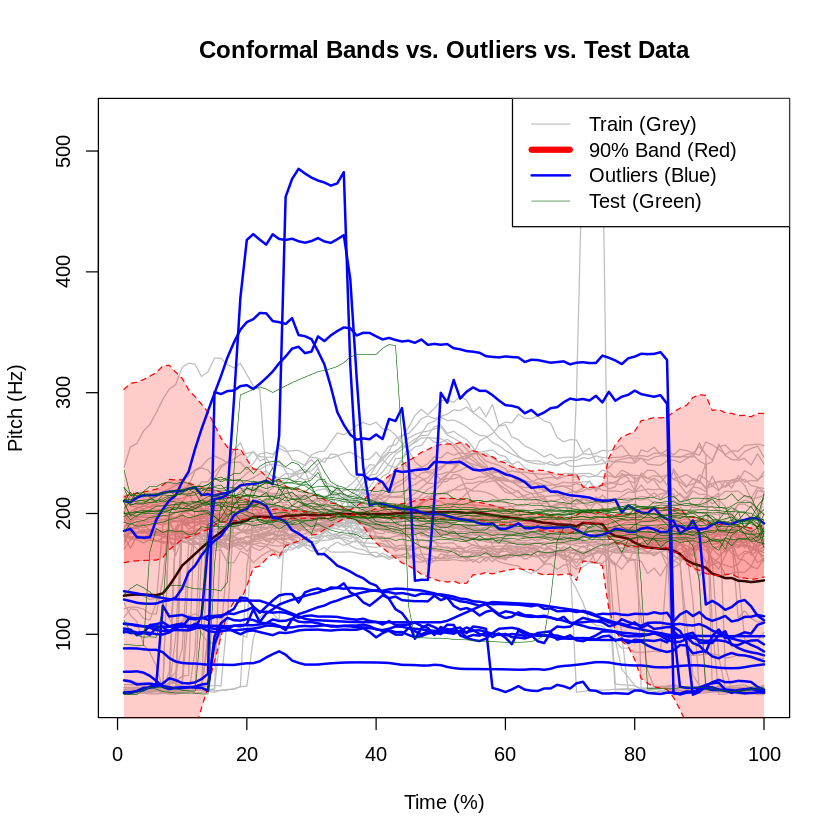

In [39]:
# Set Global Range
full_range <- range(c(data_train, X_outliers, X_test), na.rm=TRUE)

# 1. Base: Training Data
matplot(t(data_train[1:min(50, nrow(data_train)), ]), type = "l",
        col = "grey", lty = 1, ylim = full_range,
        main = "Conformal Bands vs. Outliers vs. Test Data", 
        ylab = "Pitch (Hz)", xlab = "Time (%)")

# 2. Add Mean
lines(mean_curve, col = "black", lwd = 2)

# 3. Add Conformal Bands (Red Polygons)
for (k_name in names(cluster_bands)) {
  band <- cluster_bands[[k_name]]
  poly_x <- c(1:100, 100:1)
  poly_y <- c(band$up, rev(band$lo))
  
  polygon(poly_x, poly_y, col = rgb(1, 0, 0, 0.2), border = NA)
  lines(1:100, band$up, col = "red", lty = 2)
  lines(1:100, band$lo, col = "red", lty = 2)
}

# 4. Add OUTLIERS (Blue - Should be OUTSIDE)
if (!is.null(X_outliers)) {
  matlines(t(X_outliers), col = "blue", lwd = 2, lty = 1)
}

# 5. Add NEW TEST DATA (Green - Should be INSIDE)
if (!is.null(X_test)) {
  matlines(t(X_test), col = "darkgreen", lwd = 0.5, lty = 1)
}

# 6. Legend
legend("topright", 
       legend = c("Train (Grey)", "90% Band (Red)", "Outliers (Blue)", "Test (Green)"),
       col = c("grey", "red", "blue", "darkgreen"), 
       lty = 1, lwd = c(1, 5, 2, 0.5), bg = "white")

#### The Scope of the Guarantee

It is crucial to understand **what** is being bounded by our Conformal Prediction bands.

#### 1. The Decomposition
Any curve $X(t)$ (Raw Data) is composed of two parts:
$$X(t) = \underbrace{X_{\text{proj}}(t)}_{\text{Signal (Shape)}} + \underbrace{\epsilon(t)}_{\text{Residuals (Noise)}}$$

#### 2. The Guarantee
Our method builds the bands $C(t)$ based entirely on the **PCA Space**. Therefore, the statistical guarantee ($1-\alpha$) applies **strictly** to the projected signal:
$$P\left( X_{\text{proj}}(t) \in C(t) \right) \ge 1 - \alpha$$


The choice of $K$ determines the gap between the **Raw Data** and the **Guaranteed Projection**.

* **High Variance Explained :** $X_{\text{proj}}(t) \approx X(t)$. The residuals $\epsilon(t)$ are negligible. The bands will effectively bound the raw data.
* **Low Variance Explained:** $X_{\text{proj}}(t)$ is a simplified smoothing of $X(t)$. The residuals $\epsilon(t)$ are large. You will see raw data "poking out" of the bands, even though the guarantee holds for the underlying shape.

**Action:** Ensure `K_components` is high enough to capture the true complexity of the curves (e.g., look for >95% or >99% cumulative variance).

# Testing conformal prediction Bands

make plots


*   target person Recs Vs bands
*   Other person Recs Vs bands

Comment Results